# Anonimizzazione Dataset con ARX

### Setup ambiente: installazione dipendenze Python e Java

In [1]:
# Installazione delle librerie necessarie
#!pip install --upgrade pip
#!pip install pandas numpy matplotlib
!pip install valentine jpype1 OpenAI
!apt update
!apt install -y openjdk-21-jdk



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
"apt" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"apt" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


### Inizializzazione ambiente Colab per schema matching con Valentine e integrazione OpenAI

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
import time
import json
import re
import sys
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
pp = pprint.PrettyPrinter(indent=4, sort_dicts=False)

from valentine.algorithms import Coma
from valentine.algorithms import JaccardDistanceMatcher, DistributionBased
from valentine import valentine_match
from valentine.metrics import F1Score, PrecisionTopNPercent

import jpype
import jpype.imports
from jpype.types import *
from pathlib import Path
from typing import Dict, List, Tuple, Optional

from openai import OpenAI

print("Librerie importate con successo!")
print(f"Versione Python: {sys.version}")
print(f"Versione JPype: {jpype.__version__}")

java_version = !java -version


pp.pprint(f"Versione Java {java_version}")

os.environ["OPENROUTER_API_KEY"] = ""

Librerie importate con successo!
Versione Python: 3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]
Versione JPype: 1.6.0
('Versione Java [\'openjdk version "25" 2025-09-16 LTS\', \'OpenJDK Runtime '
 "Environment Temurin-25+36 (build 25+36-LTS)', 'OpenJDK 64-Bit Server VM "
 "Temurin-25+36 (build 25+36-LTS, mixed mode, sharing)']")


### Logger centralizzato per processi
Inizializza un logger nominato che scrive log dettagliati

In [3]:
def setup_logging(log_file: str = "hierarchy_generation.log"):
    logger = logging.getLogger("HierarchyGenerator")
    logger.setLevel(logging.DEBUG)

    fh = logging.FileHandler(log_file, encoding='utf-8')
    fh.setLevel(logging.DEBUG)

    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)

    formatter = logging.Formatter(
        '[%(asctime)s] %(levelname)-8s %(name)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)

    logger.addHandler(fh)
    logger.addHandler(ch)

    return logger

logger = setup_logging()
print("✓ Logger configurato")


✓ Logger configurato


### Configurazione e Avvio della JVM con JPype

In [4]:
# Configurazione del path per il JAR di ARX
JAR_PATH = Path("/content/drive/MyDrive/Schema Matching/lib/libarx-3.9.2.jar")

print(f"Cercando JAR ARX in: {JAR_PATH}")
if not JAR_PATH.exists():
    print(f"JAR non trovato in {JAR_PATH}")
else:
    print(f"JAR trovato: {JAR_PATH}")

Cercando JAR ARX in: /content/drive/MyDrive/Schema Matching/lib/libarx-3.9.2.jar
JAR trovato: /content/drive/MyDrive/Schema Matching/lib/libarx-3.9.2.jar


In [5]:
# Avvio della JVM (JVM può essere avviata una sola volta per processo)
if not jpype.isJVMStarted():
    try:
        jpype.startJVM(classpath=[str(JAR_PATH)], convertStrings=True)
        print(f"JVM avviata con JAR: {JAR_PATH.name}")
    except Exception as e:
        print(f"Errore nell'avvio della JVM: {e}")
        raise
else:
    print("JVM già avviata")

# Importazione delle classi ARX (solo dopo l'avvio della JVM)
try:
    # Classi principali di ARX per anonimizzazione e configurazione
    from org.deidentifier.arx import ARXAnonymizer, ARXConfiguration, Data, AttributeType
    from org.deidentifier.arx import AttributeType as ARXAttr
    from org.deidentifier.arx.criteria import KAnonymity
    # Classi Java di supporto
    from java.nio.charset import StandardCharsets
    from java.io import File

    JChar = jpype.JChar
    print("Classi ARX importate con successo")
except Exception as e:
    print(f"Errore nell'importazione delle classi ARX: {e}")
    raise


JVM avviata con JAR: libarx-3.9.2.jar
Classi ARX importate con successo


# Pipeline per la Generazione e la Generalizzazione di Dataset Sintetici

## 1. Generazione Dataset Sintetici su Larga Scala
- Estensione di dataset reali duplicando i record.

- Introduzione di rumore gaussiano controllato nelle colonne numeriche per aumentare la variabilità.

---

## 2. Pulizia Preventiva delle Colonne Numeriche
- Imputazione valori mancanti tramite moda, media o mediana.

- Clipping valori entro un intervallo definito (es. 1–100).

- Conversione facoltativa a interi tramite arrotondamento.

---

## 3. Creazione Automatica delle Gerarchie
- Numeriche: gerarchie multi-livello con intervalli ad ampiezza crescente, inclusi valore originale e livello radice *.

- Categoriche: gerarchie generate via LLM (OpenRouter) con batch e parsing robusto.

---

## 4. Normalizzazione e Validazione Gerarchie
- Estrazione sicura di JSON da testo potenzialmente rumoroso (rimozione markdown, uso di regex).

- Uniformazione delle righe: taglio o padding con valori General e ultimo livello sempre *.

- Controllo copertura valori e fallback per garantire completezza.

---

## 5.Orchestrazione e Output Finale
- Pipeline integrata: pulizia dati → generazione gerarchie → validazione.

- Salvataggio gerarchie in CSV separati per colonna (; come separatore, senza header/indice).

- Output: DataFrame normalizzato e mappa colonna-file gerarchia, compatibile con ARX.



### Inizializzazione delle Cartelle di Progetto
Crea le directory di lavoro per dati grezzi, dati anonimizzati e gerarchie.

In [6]:
# Cartella progetto
dir_url = "/content/drive/MyDrive/Schema Matching"
PROJ = Path(dir_url)

# Dati Grezzi
RAW = PROJ / "raw"
RAW.mkdir(exist_ok=True)

# Dati Anonimizzati
ANON = PROJ / "anon"
ANON.mkdir(exist_ok=True)

# Gerarchie
base_dir = Path("/content/drive/MyDrive/Schema Matching/hierarchies")
#base_dir = Path("/content/drive/MyDrive/Schema Matching/generalization/hierarchies")
HIERARCHY = base_dir
HIERARCHY.mkdir(parents=True, exist_ok=True)

print("Directory:")
print(f"  Progetto: {PROJ}")
print(f"  Dati raw: {RAW}")
print(f"  Dati anonimizzati: {ANON}")
print(f"  Gerarchie: {HIERARCHY}")

Directory:
  Progetto: /content/drive/MyDrive/Schema Matching
  Dati raw: /content/drive/MyDrive/Schema Matching/raw
  Dati anonimizzati: /content/drive/MyDrive/Schema Matching/anon
  Gerarchie: /content/drive/MyDrive/Schema Matching/hierarchies


## Caricamento dei Dataset
Scarica due dataset e li salva localmente in formato CSV

In [7]:
# Caricamento dei dataset originali
base_url = "http://dbgroup.ing.unimore.it/DatasetPandas/Anonimizzato/"

print("Scaricamento dataset")
df1 = pd.read_csv(base_url + "df1.csv")
df2 = pd.read_csv(base_url + "df2.csv")

# Salvataggio locale
df1_path = RAW / "df1.csv"
df2_path = RAW / "df2.csv"

# Salva i DataFrame su disco in formato CSV senza colonna indice
df1.to_csv(df1_path, index=False)
df2.to_csv(df2_path, index=False)

SOURCES = {'S1': df1, 'S2': df2}

df1 = pd.read_csv(RAW / 'df1.csv')
df2 = pd.read_csv(RAW / 'df2.csv')

print(df1.head())

Scaricamento dataset
  native_exponential native_uniform_bias  eta_45_normal  eta_exponential5  \
0            Ecuador           Guatemala             45                 1   
1             Canada            Columbia             58                 8   
2              South            Scotland             28                15   
3              South          Yugoslavia             64                63   
4             Taiwan             Ecuador             39                39   

   eta_70_normal native_uniform native_exponential_bias  eta_uniform5  \
0             71           Laos         Trinadad&Tobago            84   
1             70           Laos                Scotland            84   
2             74        England                    Cuba            49   
3             65        Vietnam                Thailand            71   
4             68       Thailand                Scotland            88   

  native_normal  
0           USA  
1           USA  
2        France  
3    

### Generatore di dataset sintetico con duplicazione e rumore controllato

Espande un DataFrame fino a una dimensione target duplicando le righe e aggiungendo rumore alle colonne numeriche

In [8]:
# Numero righe desiderato
TARGET_ROWS = 1000

def generate_large_dataset(original_df, target_rows, noise_factor):
    """
    Genera un dataset più grande duplicando e aggiungendo rumore ai dati originali.

    Parameters:
    -----------
    original_df : pd.DataFrame
        Dataset originale da espandere
    target_rows : int
        Numero di righe target
    noise_factor : float
        Fattore di rumore per colonne numeriche (0.1 = 10% di variazione)

    Returns:
    --------
    pd.DataFrame : Dataset espanso con rumore
    """

    # Calcola quante volte duplicare
    num_copies = int(np.ceil(target_rows / len(original_df)))
    print(f"   - Righe originali: {len(original_df)}")
    print(f"   - Duplicazioni necessarie: {num_copies}")


    copies = []
    for i in range(num_copies):
        # Crea una copia del dataframe
        df_copy = original_df.copy()

        # Aggiungi rumore alle colonne numeriche
        for col in df_copy.columns:
            try:
                # Prova a convertire in numerico
                numeric_values = pd.to_numeric(df_copy[col], errors='coerce')

                # Se almeno il 50% dei valori è numerico, aggiungi rumore
                if numeric_values.notna().sum() / len(df_copy) > 0.5:
                    value_range = numeric_values.max() - numeric_values.min()

                    # Genera rumore gaussiano centrato in 0 e scala col range * noise_factor
                    noise = np.random.normal(0, value_range * noise_factor, len(df_copy))

                    # Applica il rumore solo ai valori numerici
                    mask = numeric_values.notna()
                    df_copy.loc[mask, col] = (numeric_values[mask] + noise[mask]).round().astype(int)

                    # Mantiene i valori entro il range originale
                    df_copy.loc[mask, col] = df_copy.loc[mask, col].clip(
                        lower=numeric_values.min(),
                        upper=numeric_values.max()
                    )
            except:
                # Se la colonna non è numerica o causa errori
                pass

         # Mescola le righe per aumentare la variabilità
        df_copy = df_copy.sample(frac=1, random_state=42 + i).reset_index(drop=True)
        copies.append(df_copy)

   # Concatena tutte le copie
    large_df = pd.concat(copies, ignore_index=True)

    # Taglia al numero esatto di righe target
    large_df = large_df.head(target_rows)

    # Shuffla il dataset finale
    large_df = large_df.sample(frac=1, random_state=999).reset_index(drop=True)
    print(f"   - Righe finali generate: {len(large_df)}")
    print("-" * 70)
    return large_df

### Crea versioni più grandi di due dataset con rumore, le salva su disco e confronta dimensioni con gli originali.

In [9]:
# Genera i due dataset grandi
large_df1 = generate_large_dataset(df1, TARGET_ROWS, noise_factor=0.15)
large_df2 = generate_large_dataset(df2, TARGET_ROWS, noise_factor=0.15)

# Salva i nuovi dataset
large_df1_path = RAW / "df1.csv"
large_df2_path = RAW / "df2.csv"

large_df1.to_csv(large_df1_path, index=False)
large_df2.to_csv(large_df2_path, index=False)

# Mostra statistiche di confronto
print("\n Statistiche comparative")

comparison_data = {
    'Dataset': ['df1 (originale)', 'large_df1 (nuovo)', 'df2 (originale)', 'large_df2 (nuovo)'],
    'Righe': [len(df1), len(large_df1), len(df2), len(large_df2)],
    'Colonne': [len(df1.columns), len(large_df1.columns), len(df2.columns), len(large_df2.columns)]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Mostra sample dei nuovi dataset
print("\nSample large_df1 (prime 5 righe):")
print(df1.head())

print("\nSample large_df2 (prime 5 righe):")
print(df2.head())

   - Righe originali: 637
   - Duplicazioni necessarie: 2
   - Righe finali generate: 1000
----------------------------------------------------------------------
   - Righe originali: 730
   - Duplicazioni necessarie: 2
   - Righe finali generate: 1000
----------------------------------------------------------------------

 Statistiche comparative
          Dataset  Righe  Colonne
  df1 (originale)    637        9
large_df1 (nuovo)   1000        9
  df2 (originale)    730        8
large_df2 (nuovo)   1000        8

Sample large_df1 (prime 5 righe):
  native_exponential native_uniform_bias  eta_45_normal  eta_exponential5  \
0            Ecuador           Guatemala             45                 1   
1             Canada            Columbia             58                 8   
2              South            Scotland             28                15   
3              South          Yugoslavia             64                63   
4             Taiwan             Ecuador             39     

### Pulizia e normalizzazione delle colonne numeriche in un DataFrame

Identifica le colonne prevalentemente numeriche, imputa i mancanti (media o limite inferiore), applica clipping al range e converte a interi, lasciando invariate le colonne categoriali.

In [10]:
def clean_numerical_data(df: pd.DataFrame, method:str, valid_range: Tuple[int, int]) -> pd.DataFrame:
    logger.info(f"PULIZIA NUMERICA (range: {valid_range[0]}-{valid_range[1]})")
    df_clean = df.copy()
    # Limiti inferiori e superiori del range
    lo, hi = valid_range

    # Determina se la colonna può essere considerata numerica
    for col in df_clean.columns:
        series_num = pd.to_numeric(df_clean[col], errors='coerce')
        is_numeric = series_num.notna().sum() / len(df_clean) > 0.5

        if is_numeric:
            # Se il metodo è "mean", usa la media per riempire i NaN
            # altrimenti usa il limite inferiore del range
            fill_value = series_num.mean() if method == 'mean' else lo

            # Se la media è NaN (es. colonna vuota), fallback al limite inferiore
            fill_value = lo if np.isnan(fill_value) else fill_value

            series_num = series_num.fillna(fill_value).clip(lower=lo, upper=hi).round().astype(int)
            df_clean[col] = series_num
            # Log per indicare che la colonna è numerica e quanti valori unici ha
            logger.info(f"  {col}: numerica ({series_num.nunique()} unici)")
        else:
            # La colonna non viene toccata perché è considerata categorica
            logger.info(f"  {col}: categorica ({series_num.nunique()} unici)")

    # Ritorna il DataFrame ripulito
    return df_clean

print("Pulizia numerica configurata")


Pulizia numerica configurata


# Gerarchie


### Configurazione del client OpenRouter

Crea e restituisce un client OpenRouter, ritorna None se la API key manca o se l’inizializzazione fallisce.

In [11]:
def setup_openrouter_client() -> Optional[OpenAI]:
    """Setup client OpenRouter con interfaccia OpenAI-compatibile."""

    # Configura OpenRouter API key
    api_key = os.environ.get("OPENROUTER_API_KEY")

    if not api_key:
        logger.warning("OPENROUTER_API_KEY non trovata nelle variabili d'ambiente!")
        logger.warning("Imposta con: export OPENROUTER_API_KEY='your-key'")
        return None

    # Istanzia il client OpenAI puntando all'API di OpenRouter
    try:
        client = OpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=api_key,
            default_headers={
                "HTTP-Referer": "http://localhost:8000",
                "X-Title": "ARX Data Anonymization"
            }
        )
        logger.info("Client OpenRouter configurato correttamente")
        return client
    except Exception as e:
        logger.error(f"Errore nella configurazione OpenRouter: {e}")
        return None
client = setup_openrouter_client()

[2025-11-21 07:52:26] INFO     HierarchyGenerator - Client OpenRouter configurato correttamente
INFO:HierarchyGenerator:Client OpenRouter configurato correttamente


### Normalizzazione delle righe di gerarchie

Rende ogni riga della gerarchia lunga esattamente n_levels, riempiendo o tagliando e assicurando che l’ultimo livello sia sempre il jolly '*'.

In [12]:
def normalize_hierarchy_auto(hierarchy: List[List], n_levels: int) -> List[List]:
    """
    NORMALIZZAZIONE INTELLIGENTE:
    - Se una riga ha PIÙ colonne: prendi le prime n_levels, metti '*' all'ultimo
    - Se una riga ha MENO colonne: aggiungi '*' fino a n_levels
    - Gestisce inconsistenze minori del modello LLM
    """
    normalized = []

    for i, row in enumerate(hierarchy):
        row = [str(v).strip() for v in row]

        # Se ha più colonne, accorcia
        if len(row) > n_levels:
            logger.debug(f"  [Row {i}] Ridotta da {len(row)} a {n_levels} colonne")
            row = row[:n_levels-1]  # Prendi tutto tranne l'ultimo
            row.append("*")  # Aggiungi '*' come ultimo

        # Se ha meno colonne, estendi
        elif len(row) < n_levels:
            logger.debug(f"  [Row {i}] Estesa da {len(row)} a {n_levels} colonne")
            while len(row) < n_levels - 1:
                row.append("General")  # Generalizzazione di default
            row.append("*")  # Assicura '*' all'ultimo

        # Assicura che l'ultimo sia '*'
        if row[-1] != "*":
            row[-1] = "*"

        normalized.append(row)

    logger.debug(f"Normalizzazione completata: {len(normalized)} righe")
    return normalized

print("✓ Normalizzazione intelligente configurata")


✓ Normalizzazione intelligente configurata


### Validazione di gerarchie con normalizzazione e controlli di copertura

Normalizza la gerarchia, esegue controlli di consistenza strutturale e di copertura dei valori, e restituisce esito, messaggio e una versione riparata della gerarchia.

In [13]:
def validate_hierarchy_with_recovery(
    hierarchy: List[List],
    values: List,
    n_levels: int
) -> Tuple[bool, str, Optional[List[List]]]:
    """
    Validazione INTELLIGENTE che cerca di RIPARARE gli errori.
    Ritorna: (is_valid, message, repaired_hierarchy)
    """

    # Tentativo 1: Normalizza prima
    logger.debug("  [Validate] Normalizzazione preventiva")
    hierarchy = normalize_hierarchy_auto(hierarchy, n_levels)

    values_set = set(str(v) for v in values)
    hierarchy_str = [[str(x) for x in row] for row in hierarchy]

    # Check 1: Numero righe
    expected_rows = len(values_set)
    actual_rows = len(hierarchy_str)
    if actual_rows != expected_rows:
        logger.warning(f"  [Validate] Righe mismatch: attese {expected_rows}, trovate {actual_rows}")
        # Potrebbe comunque funzionare

    # Check 2: Colonne per riga (dopo normalizzazione dovrebbe essere OK)
    for i, row in enumerate(hierarchy_str):
        if len(row) != n_levels:
            return False, f"Riga {i}: {len(row)} colonne != {n_levels}", None

    # Check 3: Ultimo elemento = '*'
    for i, row in enumerate(hierarchy_str):
        if row[-1] != "*":
            return False, f"Riga {i}: ultimo elemento non è '*'", None

    # Check 4: Primo elemento in valori originali (solo se ci sono abbastanza valori)
    if actual_rows >= 3:  # Solo se abbiamo abbastanza dati
        first_elements = set(row[0] for row in hierarchy_str)
        # Controlla che almeno il 80% dei valori siano coperti
        intersection = first_elements & values_set
        coverage = len(intersection) / len(values_set) if values_set else 0
        logger.debug(f"  [Validate] Coverage: {coverage*100:.1f}% ({len(intersection)}/{len(values_set)})")

        if coverage < 0.8:
            return False, f"Coverage insufficiente: {coverage*100:.1f}%", None

    # Check 5: No righe completamente nulle
    for i, row in enumerate(hierarchy_str):
        if all(str(v).strip() == "" for v in row):
            return False, f"Riga {i}: vuota", None

    logger.debug(f"  [Validate] Validazione passata (normalizzata)")
    return True, "OK", hierarchy  # Ritorna la versione normalizzata

print("Validazione intelligente configurata")


Validazione intelligente configurata


### Estrazione e normalizzazione robusta di JSON da testo libero

Estrae un array JSON da testo rumoroso tramite parsing diretto, normalizzandolo poi a gerarchia con normalize_hierarchy_rows.

In [14]:
def extract_json_safely(text: str, n_levels: int) -> Optional[List[List]]:
    """
    Estrae un array JSON da una risposta LLM in modo robusto.
    Usa più strategie:
    1. Parse diretto
    2. Rimozione di eventuale markdown
    3. Parse della versione "pulita"
    4. Ultimo tentativo tramite regex
    """

    logger.debug(f"  [Parse] Tentativo parsing...")
    logger.debug(f"  [Parse] Input length: {len(text)} chars")

    # --- Tentativo 1: parse diretto del testo ---
    try:
        result = json.loads(text)

        # Alcuni LLM rispondono con un dict contenente la lista come valore
        if isinstance(result, dict):
            for v in result.values():
                if isinstance(v, list) and len(v) > 0:
                    result = v
                    break

        # Lista valida
        if isinstance(result, list) and len(result) > 0:
            logger.debug(f"  [Parse] Parse diretto riuscito ({len(result)} righe)")
            return result

    except json.JSONDecodeError as e:
        logger.debug(f"  [Parse] Parse diretto fallito: {e}")

    # --- Tentativo 2: Rimuovi markdown ---
    text_clean = text
    if "```json" in text_clean:
        text_clean = text_clean.split("```json")[1].split("```")[0]
    elif "```" in text_clean:
        text_clean = text_clean.split("```")[1].split("```")[0]

    text_clean = text_clean.strip()

    # --- Tentativo 3: Parse su versione pulita ---
    try:
        result = json.loads(text_clean)
        # Anche qui validazione se il contenuto è un dict
        if isinstance(result, dict):
            for v in result.values():
                if isinstance(v, list):
                    result = v
                    break

        if isinstance(result, list) and len(result) > 0:
            logger.debug(f"  [Parse] Parse su versione pulita riuscito ({len(result)} righe)")
            return result
    except json.JSONDecodeError:
        pass

    # --- Tentativo 4: fallback per estrarre la prima lista ---
    match = re.search(r'(\[.*?\])', text_clean, re.DOTALL)
    if match:
        try:
            result = json.loads(match.group(1))
            if isinstance(result, list) and len(result) > 0:
                logger.debug(f"  [Parse] Parse via regex riuscito ({len(result)} righe)")
                return result
        except:
            pass

    # --- Fallimento finale: nessun JSON valido trovato ---
    logger.debug(f"  [Parse] Nessun JSON valido trovato")
    logger.debug(f"  [Parse] Raw text (primi 200 chars): {text[:200]}")
    return None

print("Estrazione JSON robusta configurata correttamente")

Estrazione JSON robusta configurata correttamente


### Generazione e validazione automatica di gerarchie categoriali via LLM con retry e recovery

Interroga un LLM a batch per generare una gerarchia categoriale a n livelli, con prompt, parsing/validazione e retry.

In [15]:
def generate_categorical_hierarchy(
    client: OpenAI,
    column_name: str,
    values: List,
    n_levels: int,
    model: str,
    batch_size: int,
    temperature: float,
    max_retries: int = 4
) -> List[List]:
    """
    Genera una gerarchia di generalizzazione per dati categorici tramite LLM.
    """

    if client is None:
        raise RuntimeError(f"Client OpenRouter richiesto")

    total_hierarchy = []
    # Normalizza i valori a stringhe e calcola l'insieme dei valori unici
    values = [str(v) for v in values]
    unique_values = set(values)

    # Elaborazione a batch
    for batch_idx in range(0, len(values), batch_size):
        batch_vals = list(set(values[batch_idx:batch_idx+batch_size]))
        batch_num = batch_idx // batch_size + 1

        success = False
        last_error = None

        # Retry loop
        for attempt in range(1, max_retries + 1):
            try:
                logger.info(f"[{column_name}, Batch {batch_num}] Tentativo {attempt}/{max_retries} ({len(batch_vals)} valori)")

                # Costruzione prompt con esempi
                example_rows = [
                    f'  ["{batch_vals[0]}", "Categoria_A", "Tipo_1", "*"]',
                    f'  ["{batch_vals[1] if len(batch_vals) > 1 else "altro"}", "Categoria_B", "Tipo_2", "*"]'
                ]
                example_str = ",\n".join(example_rows)

                prompt = f"""
**ORDINE**: Genera una gerarchia di generalizzazione in formato JSON.

**CONTESTO**:
- **Dominio**: {column_name}
- **Valori di Input**: {batch_vals}

**REGOLE IMPERATIVE (NON NEGOZIABILI)**:
1.  **CONSISTENZA ASSOLUTA**: Un valore di input deve avere SEMPRE lo stesso percorso.
2.  **FORMATO**: ESCLUSIVAMENTE un array JSON. No markdown.
3.  **DIMENSIONI**: Esattamente {len(batch_vals)} righe e {n_levels} colonne per riga.
4.  **STRUTTURA**: [ValoreInput, Livello1, Livello2, ..., "*"]
5.  **TERMINATORE**: L'ultimo elemento deve essere "*".

**ESEMPIO DI OUTPUT CORRETTO (per n_levels={n_levels})**:
```json
"""
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {
                            "role": "system",
                            "content": f"Sei un esperto di data anonymization. DEVI rispondere con JSON puro a {n_levels} colonne. Niente markdown."
                        },
                        {"role": "user", "content": prompt}
                    ],
                    temperature=max(0.05, temperature),
                    max_tokens=2500,
                    top_p=0.85
                )
                raw_text = response.choices[0].message.content

                # Parsing del JSON
                batch_hierarchy = extract_json_safely(raw_text, n_levels)
                if batch_hierarchy is None:
                    raise ValueError("Parse JSON ritorna None")

                # Validazione
                is_valid, msg, repaired = validate_hierarchy_with_recovery(batch_hierarchy, batch_vals, n_levels)

                if not is_valid:
                    raise ValueError(f"Validazione fallita: {msg}")

                if repaired is not None:
                    batch_hierarchy = repaired

                # Successo
                total_hierarchy.extend(batch_hierarchy)
                logger.info(f"[{column_name}, Batch {batch_num}] Successo ({len(batch_hierarchy)} righe)")
                success = True
                break

            except Exception as e:
                logger.warning(f"[{column_name}, Batch {batch_num}] Tentativo {attempt} fallito: {str(e)[:100]}")
                last_error = str(e)
                if attempt < max_retries:
                    time.sleep(2 ** attempt)

        if not success:
            raise RuntimeError(f"ERRORE CRITICO Batch {batch_num}: {last_error}")

    # Controllo finale
    values_in_hier = set(str(row[0]) for row in total_hierarchy)
    missing = unique_values - values_in_hier

    if missing:
        logger.warning(f" {len(missing)} valori potenzialmente mancanti.")

    logger.info(f" Gerarchia per '{column_name}': {len(total_hierarchy)} righe generate.")
    return total_hierarchy

### Gerarchia di generalizzazione per valori numerici con range progressivi per livello

Crea, per ogni valore numerico, una riga gerarchica con intervalli sempre più ampi a ciascun livello e jolly finale, clampando i valori al range [0, max_value-1].

In [16]:
def generate_numeric_hierarchy_complete(values: List[int], n_levels: int, max_value: int = 100) -> List[List[str]]:

    # Questa lista conterrà, per ogni livello della gerarchia,
    # le fasce numeriche generate (es. livello 1: 0-4, 5-9, 10-14, ...)
    ranges_per_level = []
    for level in range(1, n_levels + 1):
        # La grandezza della fascia raddoppia a ogni livello:
        # livello 1 → 5, livello 2 → 10, livello 3 → 20
        step = 5 * (2 ** (level - 1))
        step = min(step, max_value)

        level_ranges = []
        i = 0
        # Crea le fasce incrementali [start, end]
        while i < max_value:
            end = min(i + step - 1, max_value - 1)
            level_ranges.append((i, end))
            i += step
        # Salva la lista delle fasce per questo livello
        ranges_per_level.append(level_ranges)

    # Costruzione della gerarchia finale per ogni valore richiesto
    hierarchy = []
    for v in values:
        # Clamping: evita valori fuori range
        v_clamped = max(0, min(v, max_value - 1))
        # Ogni riga inizia con il valore originale
        row = [str(v)]

        # Per ciascun livello della gerarchia, trova la fascia in cui rientra v
        for level_ranges in ranges_per_level:
            label = None
            for (start, end) in level_ranges:
                if start <= v_clamped <= end:
                    label = f"{start}-{end}"
                    break
            # Fallback: se per qualche motivo non trova la fascia
            if label is None:
                label = f"0-{max_value - 1}"
            row.append(label)
        # Il livello più alto della gerarchia usa l'aggregazione totale
        row.append("*")
        # Aggiunge la riga completa alla gerarchia
        hierarchy.append(row)
    return hierarchy

print("Generazione numerica configurata")


Generazione numerica configurata


### Selezione della strategia di generazione gerarchica per colonne numeriche o categoriali

Sceglie automaticamente tra una generazione deterministica per colonne numeriche e una generazione via LLM, restituendo la gerarchia a n livelli.

In [17]:
def generate_hierarchy(
    df: pd.DataFrame,
    column: str,
    client: OpenAI,
    n_levels: int,
    model: str,
    temperature: float,
    batch_size: int
) -> List[List]:

    values = df[column].dropna().unique().tolist()
    is_numeric = pd.api.types.is_numeric_dtype(df[column])

    logger.info(f"  Colonna: '{column}' | Tipo: {'Numerico' if is_numeric else 'Categorico'} | Valori: {len(values)}")

    if is_numeric:
        logger.info(f"    → Numerica (deterministica)")
        hierarchy = generate_numeric_hierarchy_complete(values, n_levels, max_value=100)
    else:
        logger.info(f"    → Categorica (LLM x4, normalizzazione automatica)")
        hierarchy = generate_categorical_hierarchy(
            client=client,
            column_name=column,
            values=values,
            n_levels=n_levels,
            model=model,
            batch_size=batch_size,
            temperature=temperature,
            max_retries=4
        )

    logger.info(f"     Generata ({len(hierarchy)} righe)")
    return hierarchy

print(" Selezione strategia configurata")


 Selezione strategia configurata


### Pipeline completa per pulizia dati, generazione gerarchie e salvataggio per dataset multipli

Esegue una pipeline: pulisce i dati, genera gerarchie per ogni colonna (numeriche o categoriali via LLM), salva i risultati su disco e produce un riepilogo per ciascun dataset.

In [18]:
def process_hierarchy_generation(
    df_dict: Dict[str, pd.DataFrame],
    output_base_dir: Path,
    method: str,
    n_levels: int,
    model: str,
    temperature: float,
    batch_size: int,
    client: OpenAI
) -> Dict:
    """Pipeline: prompt migliore, validazione intelligente, normalizzazione automatica."""

    logger.info("\n" + "="*80)
    logger.info("WORKFLOW: PULIZIA → GERARCHIE (LLM MIGLIORATO) → SALVATAGGIO")
    logger.info("="*80)

    all_results = {}

    for dataset_name, df in df_dict.items():
        logger.info(f"\nProcessando dataset: {dataset_name}")
        logger.info("-" * 60)

        df_clean = clean_numerical_data(df, valid_range=(1, 100), method=method)
        original_file_path = RAW / f"{dataset_name}.csv"
        df_clean.to_csv(original_file_path, index=False)
        logger.info(f"✓ Dati salvati: {original_file_path.name}")

        hierarchy_files = {}

        for col in df_clean.columns:
            try:
                hierarchy = generate_hierarchy(
                    df=df_clean,
                    column=col,
                    client=client,
                    n_levels=n_levels,
                    model=model,
                    temperature=temperature,
                    batch_size=batch_size
                )

                if not hierarchy or len(hierarchy) == 0:
                    raise RuntimeError(f"Gerarchia vuota")

                output_dir = output_base_dir / dataset_name
                output_dir.mkdir(parents=True, exist_ok=True)

                hierarchy_path = output_dir / f"{dataset_name}_hierarchy_{col}.csv"
                df_hier = pd.DataFrame(hierarchy)
                df_hier.to_csv(hierarchy_path, sep=';', header=False, index=False)

                if not hierarchy_path.exists() or hierarchy_path.stat().st_size == 0:
                    raise RuntimeError(f"Salvataggio fallito")

                file_size = hierarchy_path.stat().st_size
                logger.info(f"  ✓ {col}: {len(hierarchy)} righe ({file_size} bytes)")
                hierarchy_files[col] = hierarchy_path

            except Exception as e:
                logger.error(f" [ERROR]  {col}: {str(e)}")
                raise

        all_results[dataset_name] = {
            'df_clean': df_clean,
            'hierarchies': hierarchy_files,
            'status': 'SUCCESS'
        }

    logger.info("\n" + "="*80)
    logger.info(" WORKFLOW COMPLETATO")
    logger.info("="*80)

    return all_results

print(" Pipeline configurata")


 Pipeline configurata


### Esecuzione del workflow

Avvia la pipeline su due DataFrame

In [19]:
method='mean'
n_levels=3    # con 4 errore
model="meta-llama/llama-3.1-70b-instruct"
temperature=0.05
batch_size=3  # RIDOTTO: meno errori

In [20]:
df1 = pd.read_csv(RAW / "df1.csv")
df2 = pd.read_csv(RAW / "df2.csv")

print(f"Dati caricati: df1={df1.shape}, df2={df2.shape}\n")


try:
    results = process_hierarchy_generation(
        df_dict={'df1': df1, 'df2': df2},
        output_base_dir=HIERARCHY,
        method=method,
        n_levels=n_levels,
        model=model,
        temperature=temperature,
        batch_size=batch_size,
        client = client
    )

    print("\n✓✓✓ WORKFLOW COMPLETATO ✓✓✓")

except Exception as e:
    print(f"\n ERRORE: {e}")
    raise


[2025-11-21 07:52:27] INFO     HierarchyGenerator - 
INFO:HierarchyGenerator:
[2025-11-21 07:52:27] INFO     HierarchyGenerator - WORKFLOW: PULIZIA → GERARCHIE (LLM MIGLIORATO) → SALVATAGGIO


Dati caricati: df1=(1000, 9), df2=(1000, 8)



INFO:HierarchyGenerator:WORKFLOW: PULIZIA → GERARCHIE (LLM MIGLIORATO) → SALVATAGGIO
[2025-11-21 07:52:27] INFO     HierarchyGenerator - ================================================================================
INFO:HierarchyGenerator:================================================================================
[2025-11-21 07:52:27] INFO     HierarchyGenerator - 
Processando dataset: df1
INFO:HierarchyGenerator:
Processando dataset: df1
[2025-11-21 07:52:27] INFO     HierarchyGenerator - ------------------------------------------------------------
INFO:HierarchyGenerator:------------------------------------------------------------
[2025-11-21 07:52:27] INFO     HierarchyGenerator - PULIZIA NUMERICA (range: 1-100)
INFO:HierarchyGenerator:PULIZIA NUMERICA (range: 1-100)
[2025-11-21 07:52:27] INFO     HierarchyGenerator -   native_exponential: categorica (0 unici)
INFO:HierarchyGenerator:  native_exponential: categorica (0 unici)
[2025-11-21 07:52:27] INFO     HierarchyGenerator


✓✓✓ WORKFLOW COMPLETATO ✓✓✓


In [21]:
logger.info("\nVERIFICA FINALE:")

for dataset in ['df1', 'df2']:
    dataset_dir = HIERARCHY / dataset
    if dataset_dir.exists():
        files = list(dataset_dir.glob("*.csv"))
        logger.info(f"{dataset}: {len(files)} gerarchie")
        for f in sorted(files):
            try:
                size = f.stat().st_size
                df_test = pd.read_csv(f, sep=';', header=None)
                logger.info(f"  ✓ {f.name}: {len(df_test)} righe, {df_test.shape[1]} colonne")
            except Exception as e:
                logger.error(f"  ❌ {f.name}: {e}")

print("\n✓ Verifica completata")


[2025-11-21 07:57:33] INFO     HierarchyGenerator - 
VERIFICA FINALE:
INFO:HierarchyGenerator:
VERIFICA FINALE:
[2025-11-21 07:57:33] INFO     HierarchyGenerator - df1: 9 gerarchie
INFO:HierarchyGenerator:df1: 9 gerarchie
[2025-11-21 07:57:33] INFO     HierarchyGenerator -   ✓ df1_hierarchy_eta_45_normal.csv: 96 righe, 5 colonne
INFO:HierarchyGenerator:  ✓ df1_hierarchy_eta_45_normal.csv: 96 righe, 5 colonne
[2025-11-21 07:57:33] INFO     HierarchyGenerator -   ✓ df1_hierarchy_eta_70_normal.csv: 36 righe, 5 colonne
INFO:HierarchyGenerator:  ✓ df1_hierarchy_eta_70_normal.csv: 36 righe, 5 colonne
[2025-11-21 07:57:33] INFO     HierarchyGenerator -   ✓ df1_hierarchy_eta_exponential5.csv: 86 righe, 5 colonne
INFO:HierarchyGenerator:  ✓ df1_hierarchy_eta_exponential5.csv: 86 righe, 5 colonne
[2025-11-21 07:57:33] INFO     HierarchyGenerator -   ✓ df1_hierarchy_eta_uniform5.csv: 100 righe, 5 colonne
INFO:HierarchyGenerator:  ✓ df1_hierarchy_eta_uniform5.csv: 100 righe, 5 colonne
[2025-11-21 


✓ Verifica completata


### Verifica copertura dei valori

Confronta i valori della colonna con quelli della gerarchia

In [22]:
# Prendi il primo dataset disponibile nella cartella RAW_DIR
raw_csvs = sorted([p for p in RAW.glob("*.csv") if p.is_file()])
if not raw_csvs:
    raise FileNotFoundError(f"Nessun CSV trovato in: {RAW}")

first_dataset_path = raw_csvs[0]
print(f"Dataset selezionato: {first_dataset_path.name}")
df = pd.read_csv(first_dataset_path)

# Prendi la prima gerarchia disponibile (cerca in tutte le sottocartelle di HIERARCHY_DIR)
hierarchy_csvs = sorted([p for p in HIERARCHY.rglob("*.csv") if p.is_file()])
if not hierarchy_csvs:
    raise FileNotFoundError(f"Nessun file gerarchia trovato in: {HIERARCHY}")

first_hierarchy_path = hierarchy_csvs[0]
print(f"Gerarchia selezionata: {first_hierarchy_path.relative_to(HIERARCHY)}")
gerarchia = pd.read_csv(first_hierarchy_path, header=None, sep=';')

# Cerca una colonna del dataframe il cui insieme di valori abbia intersezione non vuota con quelli della gerarchia.
hier_values = set(gerarchia[0].dropna().astype(str).unique())

candidate_column = None
for col in df.columns:
    col_values = set(pd.Series(df[col]).dropna().astype(str).unique())
    if hier_values & col_values:
        candidate_column = col
        break

if candidate_column is None:
    # Se nessuna intersezione, prova comunque con la prima colonna del df per effettuare un controllo informativo
    candidate_column = df.columns[0]
    print(f"Attenzione: nessuna intersezione trovata. Procedo con la colonna: {candidate_column}")

print(f"Colonna selezionata per il controllo: {candidate_column}")

# 4) Verifica copertura dei valori
col_values = set(pd.Series(df[candidate_column]).dropna().astype(str).unique())
missing = col_values - hier_values

print(f"Valori distinti nella colonna '{candidate_column}': {len(col_values)}")
print(f"Valori distinti nella gerarchia (prima colonna): {len(hier_values)}")

if missing:
    # Stampa solo un sottoinsieme se l'insieme è grande
    sample_missing = list(sorted(missing))[:20]
    print(f"Valori presenti nei dati ma assenti in gerarchia (primi 20): {sample_missing} "
          f"... totali: {len(missing)}")
else:
    print("Tutti i valori della colonna sono coperti dalla gerarchia (prima colonna).")

Dataset selezionato: df1.csv
Gerarchia selezionata: df1/df1_hierarchy_eta_45_normal.csv
Colonna selezionata per il controllo: eta_45_normal
Valori distinti nella colonna 'eta_45_normal': 96
Valori distinti nella gerarchia (prima colonna): 96
Tutti i valori della colonna sono coperti dalla gerarchia (prima colonna).


### Caricamento Gerarchie

Carica dinamicamente file di gerarchia utilizzati per il processo di anonymization dei dati, seguendo uno standard specifico di denominazione dei file.


In [23]:
def load_hierarchy_for_column(dataset_name: str, col: str) -> 'Hierarchy':
    """
    Carica il file di gerarchia per una specifica colonna.
    I file seguono la convenzione: {dataset}_hierarchy_{column}.csv
    """
    fname = f"{dataset_name}_hierarchy_{col}.csv"

    dir_path = base_dir / dataset_name
    path = dir_path / fname
    print(f"\n Caricamento gerarchia da: {path}")
    if not path.exists():
        print(f" Problema: {path}")
        raise FileNotFoundError(f"File gerarchia non trovato: {fname}")

    try:
        print(f"\n Caricamento gerarchia per {dataset_name}.{col} da {path}")
        # Caricamento con separatore semicolon
        df_h = pd.read_csv(path, header=None, dtype=str, sep=';')
        # Riempi valori mancanti con wildcard ARX
        df_h = df_h.fillna('*')

        # Converti in formato lista per ARX
        rows = df_h.values.tolist()
        # Crea JArray per ARX
        jarr = jpype.JArray(jpype.JString, 2)(rows)

        # Crea gerarchia ARX
        hierarchy = ARXAttr.Hierarchy.create(jarr)
        print(f" Gerarchia caricata per {dataset_name}.{col}")
        return hierarchy

    except Exception as e:
        print(f" Errore nel caricamento gerarchia per {dataset_name}.{col}: {e}")
        raise

print("Funzione load_hierarchy_for_column definita")

Funzione load_hierarchy_for_column definita


## Funzione di K-Anonimizzazione con ARX

funzione implementa un sistema di k-anonimizzazione utilizzando la libreria ARX per proteggere i dati sensibili in un dataset. Il processo simula l'algoritmo OLA (Optimal Lattice Anonymization) attraverso una configurazione bottom-up con opzioni avanzate come la monotonicità pratica e il limite di soppressione. La funzione gestisce automaticamente il caricamento delle gerarchie per i quasi-identificatori, applica i modelli di privacy e salva il dataset anonimizzato risultante.

In [24]:
def count_suppressed_rows_manually(output_handle):
    """
    Conta quante righe hanno almeno una cella soppressa usando isSuppressed(row, col).
    """
    try:
        rows = int(output_handle.getNumRows())
        cols = int(output_handle.getNumColumns())
        suppressed_rows = 0

        for row in range(rows):
            for col in range(cols):
                try:
                    if output_handle.isSuppressed(row, col):
                        suppressed_rows += 1
                        break  # passa alla prossima riga
                except Exception:
                    continue  # ignora errori su singole celle

        return suppressed_rows
    except Exception as e:
        print("Errore conteggio manuale righe soppresse:", e)
        return -1


def count_suppressed_cells(output_handle):
    """
    Conta il numero totale di celle soppressive nell'output.
    """
    try:
        rows = int(output_handle.getNumRows())
        cols = int(output_handle.getNumColumns())
        count = 0
        for row in range(rows):
            for col in range(cols):
                try:
                    if output_handle.isSuppressed(row, col):
                        count += 1
                except Exception:
                    continue  # ignora errori su singole celle
        return count
    except Exception as e:
        print("Errore conteggio celle soppresse:", e)
        return -1


In [25]:
def arx_k_anonymize(input_csv, output_csv, quasi_identifiers, k,
                    separator:str, suppression_limit:float, max_gen_level: int = None):
    """
    Esegue k-anonymity via ARX e ritorna (successo: bool, stats_or_error).
    """
    input_csv = str(input_csv)
    output_csv = str(output_csv)

    print(f"\n Avvio k-anonymization:")
    print(f" Input: {input_csv}")
    print(f" Output: {output_csv}")
    print(f" k: {k}")
    print(f" QI: {quasi_identifiers}")
    print(f" Suppression limit: {suppression_limit}")

    data = None
    result = None
    data_handle = None
    output_handle = None


    try:
        # Creazione oggetto File Java e caricamento dati
        java_file = File(input_csv)
        charset = StandardCharsets.UTF_8
        sep_char = JChar(separator)
        data = Data.create(java_file, charset, sep_char)

        data_handle = data.getHandle()
        if data_handle.getNumRows() == 0:
            return False, "File vuoto o non leggibile"

        num_rows = int(data_handle.getNumRows())
        print(f" Caricate {num_rows} righe")

        # Definizione attributi e header
        definition = data.getDefinition()
        df_sample = pd.read_csv(input_csv, nrows=0)
        header = df_sample.columns.tolist()
        print(f" Colonne: {header}")

        dataset_name = Path(input_csv).stem

        # Configurazione QI e gerarchie
        print(" Configurazione QI:")
        for qi in quasi_identifiers:
            if qi not in header:
                return False, f"Colonna '{qi}' non trovata nel dataset"
            definition.setAttributeType(qi, AttributeType.QUASI_IDENTIFYING_ATTRIBUTE)
            try:
                hierarchy = load_hierarchy_for_column(dataset_name, qi)
                definition.setHierarchy(qi, hierarchy)

            #    if max_gen_level is not None:
            #     Imposta il livello massimo di generalizzazione per questo attributo.
            #      definition.setMaximumGeneralization(qi, max_gen_level)
            #      print(f"   -> Limite generalizzazione impostato a {max_gen_level} per {qi}")

            except Exception as e:
                return False, f"Fallito caricamento gerarchia per '{qi}': {e}"

        # Altre colonne insensitive
        for col in header:
            if col not in quasi_identifiers:
                definition.setAttributeType(col, ARXAttr.INSENSITIVE_ATTRIBUTE)

        # Configurazione privacy + suppression limit
        config = ARXConfiguration.create()
        config.addPrivacyModel(KAnonymity(k))
        config.setSuppressionLimit(suppression_limit)

        # Impostazioni algoritmiche (tolleranti)
        try:
            try:
                config.setAlgorithm(ARXConfiguration.AnonymizationAlgorithm.BOTTOM_UP)
                print(" Algoritmo: BOTTOM_UP")
            except Exception:
                config.setAlgorithm(ARXConfiguration.AnonymizationAlgorithm.BEST_EFFORT_BOTTOM_UP)
                print(" Algoritmo: BEST_EFFORT_BOTTOM_UP (fallback)")

            try:
                config.setPracticalMonotonicity(True)
                print(" Practical Monotonicity = True")
            except Exception as e:
                print(" Practical Monotonicity non supportata dalla versione ARX:", e)

            # parametri euristici (se supportati)
            try:
                config.setHeuristicSearchThreshold(50000)
                config.setHeuristicSearchTimeLimit(60_000)
            except Exception:
                pass

        except Exception as e:
            print(" Impossibile configurare alcune opzioni ARX:", e)

        # Anonymizer
        anonymizer = ARXAnonymizer()
        try:
            anonymizer.setMaximumSnapshotSizeDataset(0.2)
            anonymizer.setMaximumSnapshotSizeSnapshot(0.2)
            anonymizer.setHistorySize(200)
        except Exception:
            pass

        # Esecuzione
        print(" Esecuzione anonimizzazione")
        result = anonymizer.anonymize(data, config)

        if not result.isResultAvailable():
            return False, "Nessun risultato di anonimizzazione disponibile"

        # Salvataggio output
        print(output_csv)
        Path(output_csv).parent.mkdir(parents=True, exist_ok=True)
        output_handle = result.getOutput(False)
        output_handle.save(output_csv, sep_char)
        print(f" Risultato salvato in: {output_csv}")

        # Estrazione statistiche di generalizzazione
        optimum = result.getGlobalOptimum()
        generalization = {}
        for qi in quasi_identifiers:
            try:
                gen_level = optimum.getGeneralization(qi)
                generalization[qi] = int(gen_level)
            except Exception as e:
                generalization[qi] = f"Errore: {e}"

        # Conteggio righe e celle soppresse
        suppressed_rows = -1
        suppressed_cells = -1
        try:
            suppressed_rows = count_suppressed_rows_manually(output_handle)
            suppressed_cells = count_suppressed_cells(output_handle)
        except Exception as e:
            print("Errore nel conteggio righe/celle soppresse:", e)

        # Output statistiche
        if suppressed_rows >= 0:
            percent_rows = (suppressed_rows / num_rows) * 100 if num_rows > 0 else 0.0
            suppressed_count_str = f"{suppressed_rows}/{num_rows}"
            print(f" Righe soppresse: {suppressed_count_str} ({percent_rows:.2f}%)")
        else:
            suppressed_count_str = f"-1/{num_rows}"
            print(" Impossibile ottenere il conteggio righe soppresse")

        if suppressed_cells >= 0:
            print(f" Celle soppresse: {suppressed_cells}")
        else:
            print(" Impossibile ottenere il conteggio celle soppresse")

        stats = {
            "k": k,
            "generalization": generalization,
            "suppressed_str": suppressed_count_str,
            "suppressed_rows": suppressed_rows,
            "suppressed_cells": suppressed_cells,
            "total_rows": num_rows,
            "percent_suppressed_rows": percent_rows
        }

        print(f" Livelli generalizzazione: {generalization}")

        return True, stats

    except Exception as e:
        print(f" Errore durante anonimizzazione: {e}")
        import traceback
        traceback.print_exc()
        return False, str(e)

    finally:
        # Rilascia i handle per evitare lock senza assumere che getHandle esista
        if data_handle is not None:
            try:
                release_fn = getattr(data_handle, "release", None)
                if callable(release_fn):
                    release_fn()
                else:
                    pass  # ignora se non esiste
            except Exception as e:
                print(f" Impossibile rilasciare DataHandle: {e}")

        if result is not None and output_handle is not None:
            try:
                rel = getattr(output_handle, "release", None)
                if callable(rel):
                    rel()
            except Exception as e:
                print(f" Impossibile rilasciare DataHandle del risultato: {e}")

## Configurazione dei Quasi-Identificatori

Lo script stampa le colonne dei DataFrame (df1, df2, df3), un dizionario QI con le colonne attese per ciascun dataset e verifica la presenza dei file di gerarchia corrispondenti seguendo il pattern dataset_hierarchy_colonna.csv

In [26]:
# Colonne dei dataset
# Contenuto Dataset
df1 = pd.read_csv(RAW / 'df1.csv')
df2 = pd.read_csv(RAW / 'df2.csv')
for name, df in [('df1', df1), ('df2', df2)]:
    print(f"\n{name} -> colonne:", df.columns.tolist())


df1 -> colonne: ['native_exponential', 'native_uniform_bias', 'eta_45_normal', 'eta_exponential5', 'eta_70_normal', 'native_uniform', 'native_exponential_bias', 'eta_uniform5', 'native_normal']

df2 -> colonne: ['native_exponential_bias', 'eta_exponential5', 'native_uniform_bias', 'native_uniform', 'eta_uniform5', 'native_normal_bias', 'native_normal', 'eta_45_normal']


In [27]:
QI = {
    'df1.csv': ['native_exponential', 'native_uniform_bias', 'eta_45_normal', 'eta_exponential5', 'eta_70_normal', 'native_uniform', 'native_exponential_bias', 'eta_uniform5', 'native_normal'],
    'df2.csv': ['native_exponential_bias', 'eta_exponential5', 'native_uniform_bias', 'native_uniform', 'eta_uniform5', 'native_normal_bias', 'native_normal', 'eta_45_normal']
}

#QI = {
#    'df1.csv': ['native_exponential_bias', 'eta_45_normal', 'native_uniform'],
#    'df2.csv': ['native_exponential_bias', 'eta_45_normal', 'native_uniform']
#}

In [28]:
# Verifica esistenza file gerarchie
print("\n Verifica disponibilità gerarchie:")
for dataset, qi_list in QI.items():
    dataset_name = dataset.replace('.csv', '')
    print(f"\n {dataset}:")
    for qi in qi_list:
        hierarchy_file = f"{dataset_name}_hierarchy_{qi}.csv"
        dir_path = base_dir / dataset_name
        if (dir_path / hierarchy_file).exists():
            print(f" {hierarchy_file}")
        else:
            print(f" {hierarchy_file} - NON TROVATO")


 Verifica disponibilità gerarchie:

 df1.csv:
 df1_hierarchy_native_exponential.csv
 df1_hierarchy_native_uniform_bias.csv
 df1_hierarchy_eta_45_normal.csv
 df1_hierarchy_eta_exponential5.csv
 df1_hierarchy_eta_70_normal.csv
 df1_hierarchy_native_uniform.csv
 df1_hierarchy_native_exponential_bias.csv
 df1_hierarchy_eta_uniform5.csv
 df1_hierarchy_native_normal.csv

 df2.csv:
 df2_hierarchy_native_exponential_bias.csv
 df2_hierarchy_eta_exponential5.csv
 df2_hierarchy_native_uniform_bias.csv
 df2_hierarchy_native_uniform.csv
 df2_hierarchy_eta_uniform5.csv
 df2_hierarchy_native_normal_bias.csv
 df2_hierarchy_native_normal.csv
 df2_hierarchy_eta_45_normal.csv


## Esecuzione dell'Anonimizzazione

Esegue in batch procedure di k‑anonimizzazione su più file CSV, iterando diversi valori di k e salvando i risultati in sottocartelle organizzate per dataset e k. Per ogni dataset verifica la presenza di quasi‑identificatori (QI), invoca la funzione arx_k_anonymize con parametri come separator e suppression_limit, registra successo/errore in results e stampa log di avanzamento

In [29]:
# Parametri di anonimizzazione
k_values = [2, 5, 10]
separator = ','
suppression_limit= 0.2    # Valore di partenza da 0.2 -> (0.4) valore molto alto bisognerebbe aumentare il livello di gerarche
max_gen_level = 1

large_df1_path = RAW / "df1.csv"
large_df2_path = RAW / "df2.csv"
SOURCES = {'S1': df1, 'S2': df2}
# Dataset da processare
datasets = [
    (large_df1_path, 'df1.csv'),
    (large_df2_path, 'df2.csv'),
]



results = {}

print(" PROCESSO DI ANONIMIZZAZIONE")
print("=" * 60)

for input_path, dataset_name in datasets:
    if dataset_name not in QI:
        print(f"Saltando {dataset_name} - nessun QI configurato")
        continue

    results[dataset_name] = {}

    for k in k_values:
        print(f"Processando {dataset_name} con k={k}")
        print(f"{'='*50}")

        # Creazione percorso output
        out_dir = ANON / dataset_name.replace('.csv', '') / f'k={k}'
        out_file = out_dir / dataset_name

       # Esecuzione anonimizzazione
        success, info = arx_k_anonymize(
            input_csv=input_path,
            output_csv=out_file,
            quasi_identifiers=QI[dataset_name],
            k=k,
            separator=separator,
            suppression_limit=suppression_limit,
            max_gen_level = max_gen_level # FORZA ARX A FERMARSI AL LIVELLO INTERMEDIO
        )

        results[dataset_name][k] = {
            'success': success,
            'info': info,
            'status': 'SUCCESSO' if success else 'FALLITO'
        }

        status = "SUCCESSO" if success else "FALLITO"
        print(f"\n Risultato: {status}")
        if not success:
            print(f" Errore: {info}")

# Una soluzione può essere quella di diminuire in numero di QI presi in considerazione
# Aumentare suppression_limit > 0.2 e utilizzare max_gen_level che forza arx a fermarsi al livello prestabilito


 PROCESSO DI ANONIMIZZAZIONE
Processando df1.csv con k=2

 Avvio k-anonymization:
 Input: /content/drive/MyDrive/Schema Matching/raw/df1.csv
 Output: /content/drive/MyDrive/Schema Matching/anon/df1/k=2/df1.csv
 k: 2
 QI: ['native_exponential', 'native_uniform_bias', 'eta_45_normal', 'eta_exponential5', 'eta_70_normal', 'native_uniform', 'native_exponential_bias', 'eta_uniform5', 'native_normal']
 Suppression limit: 0.2
 Caricate 1000 righe
 Colonne: ['native_exponential', 'native_uniform_bias', 'eta_45_normal', 'eta_exponential5', 'eta_70_normal', 'native_uniform', 'native_exponential_bias', 'eta_uniform5', 'native_normal']
 Configurazione QI:

 Caricamento gerarchia da: /content/drive/MyDrive/Schema Matching/hierarchies/df1/df1_hierarchy_native_exponential.csv

 Caricamento gerarchia per df1.native_exponential da /content/drive/MyDrive/Schema Matching/hierarchies/df1/df1_hierarchy_native_exponential.csv
 Gerarchia caricata per df1.native_exponential

 Caricamento gerarchia da: /conten

In [30]:
# Percorso del file CSV anonimizzato
output_file = '/content/drive/MyDrive/Schema Matching/anon/df1/k=2/df1.csv'

# Lista delle colonne quasi-identificatrici (esempio)
quasi_identifiers = ['native_exponential', 'native_uniform_bias', 'eta_45_normal', 'eta_exponential5', 'eta_70_normal', 'native_uniform', 'native_exponential_bias', 'eta_uniform5', 'native_normal']

df = pd.read_csv(output_file)

for col in quasi_identifiers:
  wildcard_count = (df[col] == '*').sum()
  wildcard_pct = (wildcard_count / len(df)) * 100

  print(f"\n{col}:")
  print(f"  Wildcard: {wildcard_count}/{len(df)} ({wildcard_pct:.1f}%)")

  if wildcard_pct == 100:
    print(f" TUTTE WILDCARD!")
  elif wildcard_pct > 50:
    print(f" TROPPI WILDCARD!")
  elif wildcard_pct < 10:
    print(f"   Buono!")
  else:
    print(f"   Accettabile (ma monitora)")





native_exponential:
  Wildcard: 196/1000 (19.6%)
   Accettabile (ma monitora)

native_uniform_bias:
  Wildcard: 1000/1000 (100.0%)
 TUTTE WILDCARD!

eta_45_normal:
  Wildcard: 1000/1000 (100.0%)
 TUTTE WILDCARD!

eta_exponential5:
  Wildcard: 1000/1000 (100.0%)
 TUTTE WILDCARD!

eta_70_normal:
  Wildcard: 1000/1000 (100.0%)
 TUTTE WILDCARD!

native_uniform:
  Wildcard: 196/1000 (19.6%)
   Accettabile (ma monitora)

native_exponential_bias:
  Wildcard: 196/1000 (19.6%)
   Accettabile (ma monitora)

eta_uniform5:
  Wildcard: 1000/1000 (100.0%)
 TUTTE WILDCARD!

native_normal:
  Wildcard: 196/1000 (19.6%)
   Accettabile (ma monitora)


## Riepilogo e tabella di risultati di anonimizzazione



In [31]:
# Display risultati riassuntivi
print("RIEPILOGO RISULTATI ANONIMIZZAZIONE")
print("=" * 60)

for dataset_name, dataset_results in results.items():
    print(f"\n {dataset_name}:")
    for k, result in dataset_results.items():
        status = "SUCCESSO" if result['success'] else "FALLITO"
        print(f" k={k}: {status}")
        if result['success']:
            info = result['info']
            print(f" Generalizzazione: {info['generalization']}")
            print(f" Righe soppresse: {info['suppressed_rows']}/{info['total_rows']}")
            if info['suppressed_rows'] >= 0 and info['total_rows'] > 0:
                perc = (info['suppressed_rows'] / info['total_rows']) * 100
                print(f" Percentuale soppressione: {perc:.1f}%")
        else:
            print(f" Dettaglio errore: {result['info']}")

# Creazione tabella riassuntiva
summary_data = []
for dataset_name, dataset_results in results.items():
    for k, result in dataset_results.items():
        if result['success']:
            info = result['info']
            suppression_perc = (info['suppressed_rows'] / info['total_rows']) * 100 if info['suppressed_rows'] >= 0 else 0
            summary_data.append({
                'Dataset': dataset_name,
                'k': k,
                'Status': 'Successo',
                'Righe Totali': info['total_rows'],
                'Righe Soppresse': info['suppressed_rows'],
                'Soppressione %': f"{suppression_perc:.1f}%"
            })
        else:
            summary_data.append({
                'Dataset': dataset_name,
                'k': k,
                'Status': 'Fallito',
                'Righe Totali': '-',
                'Righe Soppresse': '-',
                'Soppressione %': '-'
            })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("\nTABELLA RIASSUNTIVA:")
    print(summary_df)

RIEPILOGO RISULTATI ANONIMIZZAZIONE

 df1.csv:
 k=2: SUCCESSO
 Generalizzazione: {'native_exponential': 1, 'native_uniform_bias': 2, 'eta_45_normal': 4, 'eta_exponential5': 4, 'eta_70_normal': 4, 'native_uniform': 1, 'native_exponential_bias': 1, 'eta_uniform5': 4, 'native_normal': 1}
 Righe soppresse: 0/1000
 Percentuale soppressione: 0.0%
 k=5: SUCCESSO
 Generalizzazione: {'native_exponential': 2, 'native_uniform_bias': 2, 'eta_45_normal': 3, 'eta_exponential5': 3, 'eta_70_normal': 2, 'native_uniform': 2, 'native_exponential_bias': 2, 'eta_uniform5': 4, 'native_normal': 2}
 Righe soppresse: 0/1000
 Percentuale soppressione: 0.0%
 k=10: SUCCESSO
 Generalizzazione: {'native_exponential': 2, 'native_uniform_bias': 2, 'eta_45_normal': 3, 'eta_exponential5': 4, 'eta_70_normal': 2, 'native_uniform': 2, 'native_exponential_bias': 2, 'eta_uniform5': 3, 'native_normal': 2}
 Righe soppresse: 0/1000
 Percentuale soppressione: 0.0%

 df2.csv:
 k=2: SUCCESSO
 Generalizzazione: {'native_exponentia

## Verifica dati anonimizzati e controllo k-anonimato

Carica i dati originali e anonimizzati con pandas e confronta dimensioni e prime righe delle colonne quasi-identificative (QI). Conta le righe con soppressione ('*') e calcola la riduzione del numero di valori unici per ogni QI per valutare la perdita di granularità dovuta all'anonimizzazione. Utile per validare la correttezza dell'output di procedure di anonimizzazione e misurarne l'impatto sulla qualità dei dati

In [33]:
# Verifica e analisi dei dati anonimizzati
print("ANALISI DATI ANONIMIZZATI")
print("=" * 60)

for dataset_name in QI.keys():
    for k in [5]:  # Verifica solo k=5 come esempio
        anon_path = ANON / dataset_name.replace('.csv', '') / f'k={k}' / dataset_name

        if anon_path.exists():
            try:
                # Caricamento dati originali e anonimizzati
                if dataset_name == 'df1.csv':
                    original_df = df1
                elif dataset_name == 'df2.csv':
                    original_df = df2

                anon_df = pd.read_csv(anon_path)

                print(f"\n{dataset_name} (k={k}):")
                print(f" Dimensioni originali: {original_df.shape}")
                print(f" Dimensioni anonimizzate: {anon_df.shape}")

                # Confronto sample
                print(f"\n Prime 3 righe originali:")
                print(original_df[QI[dataset_name]].head(3))

                print(f"\n Prime 3 righe anonimizzate:")
                print(anon_df[QI[dataset_name]].head(3))

                # Conteggio righe con soppressione
                suppressed_rows = anon_df.apply(
                    lambda row: row.astype(str).str.contains('\*').any(), axis=1
                ).sum()
                print(f"\n Righe con soppressione (*): {suppressed_rows}")

                # Analisi valori unici per ogni QI
                print(f"\n Analisi valori unici per QI:")
                for qi in QI[dataset_name]:
                    original_unique = original_df[qi].nunique()
                    anon_unique = anon_df[qi].nunique()
                    reduction = ((original_unique - anon_unique) / original_unique) * 100

                    print(f"    {qi}:")
                    print(f"      Originale: {original_unique} valori unici")
                    print(f"      Anonimizzato: {anon_unique} valori unici")
                    print(f"      Riduzione: {reduction:.1f}%")

            except Exception as e:
                print(f" Errore nella lettura di {anon_path}: {e}")
        else:
            print(f"\nFile non trovato: {anon_path}")

<>:32: SyntaxWarning: invalid escape sequence '\*'
<>:32: SyntaxWarning: invalid escape sequence '\*'
/tmp/ipython-input-3136910332.py:32: SyntaxWarning: invalid escape sequence '\*'
  lambda row: row.astype(str).str.contains('\*').any(), axis=1


ANALISI DATI ANONIMIZZATI

df1.csv (k=5):
 Dimensioni originali: (1000, 9)
 Dimensioni anonimizzate: (1000, 9)

 Prime 3 righe originali:
  native_exponential native_uniform_bias  eta_45_normal  eta_exponential5  \
0             Taiwan  Holand-Netherlands             63                54   
1            England              Canada             57                29   
2           Cambodia             Vietnam             34                45   

   eta_70_normal native_uniform native_exponential_bias  eta_uniform5  \
0             70        Ecuador                 Hungary            16   
1             57        Vietnam                  Greece             1   
2             65       Columbia           United-States            10   

  native_normal  
0         Haiti  
1           USA  
2           USA  

 Prime 3 righe anonimizzate:
  native_exponential native_uniform_bias eta_45_normal eta_exponential5  \
0                  *                   *         60-79            40-59   
1       

## Caricamento di dataset anonimizzati per k-anonimato

In [34]:
# Percorso base per i file anonimizzati
#dir_url = Path(r"C:\Davide\Università\Magistrale\Secondo Anno\Secondo Semestre\Business Intelligence\Tesina\Progetto Tesina\Schema Matching\anon")
#dir_url = Path(r"/content/drive/MyDrive/Schema Matching/anon")
print(ANON)

# Struttura organizzata per i dataset anonimizzati
anonSOURCES = {
    'df1': {},
    'df2': {}
}

# Caricamento con gestione degli errori
datasets = ['df1', 'df2']

print("Caricamento dataset anonimizzati")
for dataset in datasets:
    for k in k_values:
        try:
            file_path = os.path.join(ANON, dataset, f"k={k}", f"{dataset}.csv")
            if os.path.exists(file_path):
                # Prova prima con separatore comma, poi con punto e virgola
                try:
                    df_anon = pd.read_csv(file_path, delimiter=',')
                except:
                    df_anon = pd.read_csv(file_path, delimiter=';')

                anonSOURCES[dataset][f'k{k}'] = df_anon
                print(f" {dataset}_k{k}: {df_anon.shape}")
            else:
                print(f" File non trovato: {file_path}")
        except Exception as e:
            print(f" Errore caricamento {dataset}_k{k}: {e}")

print(anonSOURCES.keys())
print(anonSOURCES['df1'].keys())

/content/drive/MyDrive/Schema Matching/anon
Caricamento dataset anonimizzati
 df1_k2: (1000, 9)
 df1_k5: (1000, 9)
 df1_k10: (1000, 9)
 df2_k2: (1000, 8)
 df2_k5: (1000, 8)
 df2_k10: (1000, 8)
dict_keys(['df1', 'df2'])
dict_keys(['k2', 'k5', 'k10'])


## Controlli di qualità sui dataset anonimizzati

Controlli di consistenza e qualità tra dataset originali e le loro versioni anonimizzate per diversi valori di k. Per ogni coppia (dataset, k) verifica che le colonne coincidano (segnalando colonne mancanti o extra) e confronta colonna per colonna i valori, elencando quelle modificate dall'anonimizzazione.

In [35]:
# Controllo colonne tra originali e anonimizzati
for dataset in datasets:
    for k in k_values:
        k_key = f'k{k}'
        if k_key in anonSOURCES[dataset]:
            cols_original = set(SOURCES[f'S{datasets.index(dataset)+1}'].columns)
            cols_anon = set(anonSOURCES[dataset][k_key].columns)

            if cols_original == cols_anon:
                print(f"[{dataset}_{k_key}] Stesse colonne")
            else:
                diff1 = cols_original - cols_anon
                diff2 = cols_anon - cols_original
                print(f"[{dataset}_{k_key}] Colonne diverse!")
                if diff1:
                    print(f" - Mancano in anonimizzato: {diff1}")
                if diff2:
                    print(f" - Extra in anonimizzato: {diff2}")

# Controllo valori diversi colonna per colonna
print("\n ANALISI VALORI MODIFICATI DALL'ANONIMIZZAZIONE")
print("=" * 60)

for dataset in datasets:
    source_key = f'S{datasets.index(dataset)+1}'
    df_orig = SOURCES[source_key].reset_index(drop=True)

    for k in k_values:
        k_key = f'k{k}'
        if k_key in anonSOURCES[dataset]:
            df_anon = anonSOURCES[dataset][k_key].reset_index(drop=True)

            # Colonne comuni
            common_cols = df_orig.columns.intersection(df_anon.columns)
            modified_cols = []

            print(f"\n[{dataset}_{k_key}] Colonne con valori modificati:")
            for col in common_cols:
                if not df_orig[col].equals(df_anon[col]):
                    modified_cols.append(col)
                    print(f"  - {col}")

            if not modified_cols:
                print(" Nessuna colonna modificata")


[df1_k2] Stesse colonne
[df1_k5] Stesse colonne
[df1_k10] Stesse colonne
[df2_k2] Stesse colonne
[df2_k5] Stesse colonne
[df2_k10] Stesse colonne

 ANALISI VALORI MODIFICATI DALL'ANONIMIZZAZIONE

[df1_k2] Colonne con valori modificati:
  - native_exponential
  - native_uniform_bias
  - eta_45_normal
  - eta_exponential5
  - eta_70_normal
  - native_uniform
  - native_exponential_bias
  - eta_uniform5
  - native_normal

[df1_k5] Colonne con valori modificati:
  - native_exponential
  - native_uniform_bias
  - eta_45_normal
  - eta_exponential5
  - eta_70_normal
  - native_uniform
  - native_exponential_bias
  - eta_uniform5
  - native_normal

[df1_k10] Colonne con valori modificati:
  - native_exponential
  - native_uniform_bias
  - eta_45_normal
  - eta_exponential5
  - eta_70_normal
  - native_uniform
  - native_exponential_bias
  - eta_uniform5
  - native_normal

[df2_k2] Colonne con valori modificati:
  - native_exponential_bias
  - eta_exponential5
  - native_uniform_bias
  - nativ

## Confronto valori distinti tra originali e anonimizzati

Per ogni dataset e per ogni valore di k, gli insiemi di valori distinti delle colonne comuni tra i dataframe originali e quelli anonimizzati, segnalando differenze (valori presenti solo nell'originale o solo nell'anonimizzato) e costruendo una tabella riassuntiva con conteggi e percentuali di riduzione. Utilizza pandas per il confronto di set, la manipolazione dei dataframe e la generazione del sommario, ed è utile per valutare la perdita di informazione e la correttezza dell'anonimizzazione.

In [36]:
# Analisi insiemi di valori distinti
print("\nANALISI INSIEMI DI VALORI DISTINTI")
print("=" * 60)

comparison_results = []

for dataset in datasets:
    source_key = f'S{datasets.index(dataset)+1}'
    df_orig = SOURCES[source_key]

    for k in k_values:
        k_key = f'k{k}'
        if k_key in anonSOURCES[dataset]:
            df_anon = anonSOURCES[dataset][k_key]

            # Colonne comuni
            common_cols = df_orig.columns.intersection(df_anon.columns)

            print(f"\n[{dataset}_{k_key}] Controllo insiemi di valori distinti:")
            for col in common_cols:
                set_orig = set(df_orig[col].dropna().unique())
                set_anon = set(df_anon[col].dropna().unique())

                same = set_orig == set_anon
                diff1 = sorted(set_orig - set_anon)[:10]  # Primi 10
                diff2 = sorted(set_anon - set_orig)[:10]  # Primi 10
                common = sorted(set_orig & set_anon)[:10]  # Primi 10

                if same:
                    print(f" - {col}: OK (stessi valori distinti)")
                else:
                    print(f" - {col}: valori distinti diversi")
                    if diff1:
                        print(f" Solo in originale: {diff1}")
                    if diff2:
                        print(f" Solo in anonimizzato: {diff2}")

                comparison_results.append({
                    "Dataset": dataset,
                    "k": k,
                    "Colonna": col,
                    "Coincidenza": same,
                    "Solo in Orig": len(set_orig - set_anon),
                    "Solo in Anon": len(set_anon - set_orig),
                    "Comuni": len(set_orig & set_anon),
                    "Riduzione %": round((1 - len(set_anon)/len(set_orig))*100, 1) if len(set_orig) > 0 else 0
                })

# Crea DataFrame riassuntivo
df_comparison = pd.DataFrame(comparison_results)
print("\nTABELLA RIASSUNTIVA:")
print(df_comparison.head(20))

print("La colonna \"Riduzione %\" indica una consistente riduzione del numero di valori unici; ad esempio, 97% di riduzione significa che solo pochi valori unici rimangono nel dataset anonimizzato, rispetto all'originale.")



ANALISI INSIEMI DI VALORI DISTINTI

[df1_k2] Controllo insiemi di valori distinti:
 - native_exponential: valori distinti diversi
 Solo in originale: ['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador', 'England', 'France']
 Solo in anonimizzato: ['*', 'America', 'America Centrale', 'America del Nord', 'America del Sud', 'Asia', 'Asia Orientale', 'Central-America', 'Europa', 'Europe']
 - native_uniform_bias: valori distinti diversi
 Solo in originale: ['Cambodia', 'Canada', 'China', 'Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador', 'England', 'France']
 Solo in anonimizzato: ['*']
 - eta_45_normal: valori distinti diversi
 Solo in originale: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
 Solo in anonimizzato: ['*']
 - eta_exponential5: valori distinti diversi
 Solo in originale: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.in

## Costruzione Gold Standard per Schema Matching

Lo script crea un gold standard per il matching degli schemi tra più sorgenti rinominando le colonne con prefissi di origine e abbinandole quando il nome dopo il prefisso coincide. Produce mappings come coppie (A, B) e un DataFrame di ground truth utilizzabile per valutare algoritmi di schema matching o per confronti tra dataset originali e anonimizzati.

In [37]:
# Creazione Gold Standard basato sui nomi delle colonne
print(" CREAZIONE GOLD STANDARD")
print("=" * 60)

# Rinomina colonne per distinguere le sorgenti
df1_renamed = df1.copy()
df2_renamed = df2.copy()

df1_renamed.columns = ['1_' + col for col in df1_renamed.columns]
df2_renamed.columns = ['2_' + col for col in df2_renamed.columns]

# Aggiorna SOURCES con nomi delle colonne rinominati
SOURCES_RENAMED = {}
SOURCES_RENAMED['S1'] = df1_renamed
SOURCES_RENAMED['S2'] = df2_renamed

# Rinomina anche i dataset anonimizzati
anonSOURCES_RENAMED = {}
for dataset in datasets:
    anonSOURCES_RENAMED[dataset] = {}
    for k in k_values:
        k_key = f'k{k}'
        if k_key in anonSOURCES[dataset]:
            df_anon_renamed = anonSOURCES[dataset][k_key].copy()
            prefix = str(datasets.index(dataset)+1)
            df_anon_renamed.columns = [f'{prefix}_' + col for col in df_anon_renamed.columns]
            anonSOURCES_RENAMED[dataset][k_key] = df_anon_renamed

def nome_match(SOURCES, src_i, src_j):
    """Crea mapping basato sui nomi delle colonne"""
    pred = {}
    colonne_i = SOURCES[src_i].columns
    colonne_j = SOURCES[src_j].columns

    for col_i in colonne_i:
        nome_i = col_i.split("_", 1)[1] if "_" in col_i else col_i
        for col_j in colonne_j:
            nome_j = col_j.split("_", 1)[1] if "_" in col_j else col_j
            if nome_i == nome_j:
                pred[col_j] = col_i  # col_j di j mappato su col_i di i
    return pred

# Creazione mappings gold standard
GOLD_mappings_dict = {}
for i in SOURCES_RENAMED:
    for j in SOURCES_RENAMED:
        if i != j:
            pred_ij = nome_match(SOURCES_RENAMED, i, j) or {}
            key_ij = f"{i[-1]}_{j[-1]}"
            GOLD_mappings_dict[key_ij] = pred_ij.copy()

# Converti in ground truth
rows = []
for mapping in GOLD_mappings_dict.values():
    for a, b in mapping.items():
        rows.append((a, b))

GOLD_mappings_df = pd.DataFrame(rows, columns=['A', 'B'])
ground_truth_TOTALE = list(GOLD_mappings_df[['A', 'B']].itertuples(index=False, name=None))

# Esempio specifico per S1-S2
ground_truth_S1_S2 = [
    (a, b) for (a, b) in ground_truth_TOTALE
    if a.startswith("1_") and b.startswith("2_")
]

print(f"Ground truth totale: {len(ground_truth_TOTALE)} mappings")
print(f"Ground truth S1-S2: {len(ground_truth_S1_S2)} mappings")
print("\nGround truth S1-S2:")
for match in ground_truth_S1_S2[:5]:
    print(f"  {match}")


 CREAZIONE GOLD STANDARD
Ground truth totale: 14 mappings
Ground truth S1-S2: 7 mappings

Ground truth S1-S2:
  ('1_native_exponential_bias', '2_native_exponential_bias')
  ('1_eta_exponential5', '2_eta_exponential5')
  ('1_native_uniform_bias', '2_native_uniform_bias')
  ('1_native_uniform', '2_native_uniform')
  ('1_eta_uniform5', '2_eta_uniform5')


## Schema matching Distribution-Based su Dati Originali

Schema matching tra due sorgenti (S1 e S2) utilizzando il matcher DistributionBased via la funzione valentine_match, trovando corrispondenze basate sulla distribuzione dei valori. Genera i match rilevati, ne ottiene una versione one-to-one e calcola metriche di valutazione confrontando i risultati con il ground truth (ground_truth_S1_S2)

In [38]:
print("SCHEMA MATCHING SUI DATI ORIGINALI")
print("=" * 60)

# Applicazione Distribution-based Matcher sui dati originali
matcher = DistributionBased(process_num=2)
matches_S1_S2_original = valentine_match(SOURCES_RENAMED['S1'], SOURCES_RENAMED['S2'], matcher)

print("\n Matches trovati sui dati originali (S1-S2):")
pp.pprint(dict(list(matches_S1_S2_original.items())[:10]))

# One-to-one matching
matches_S1_S2_one_to_one = matches_S1_S2_original.one_to_one()
print(f"\n One-to-one matches: {len(matches_S1_S2_one_to_one)}")

# Metriche sui dati originali
metrics_original = matches_S1_S2_original.get_metrics(ground_truth_S1_S2)
print("\n METRICHE SUI DATI ORIGINALI:")
print("Ground truth utilizzato:")
pp.pprint(ground_truth_S1_S2[:3])
print("\nScores:")
pp.pprint(metrics_original)


SCHEMA MATCHING SUI DATI ORIGINALI

 Matches trovati sui dati originali (S1-S2):
{   (('table_1', '1_native_exponential_bias'), ('table_2', '2_native_exponential_bias')): 0.9954770715661452,
    (('table_1', '1_eta_uniform5'), ('table_2', '2_eta_uniform5')): 0.9911849406832557,
    (('table_1', '1_eta_exponential5'), ('table_2', '2_eta_exponential5')): 0.9908932194592555,
    (('table_1', '1_native_normal'), ('table_2', '2_native_normal')): 0.9908502753597198,
    (('table_1', '1_eta_45_normal'), ('table_2', '2_eta_45_normal')): 0.9886195760084319,
    (('table_1', '1_native_uniform'), ('table_2', '2_native_uniform_bias')): 0.9877040919169522,
    (('table_1', '1_native_uniform_bias'), ('table_2', '2_native_uniform_bias')): 0.9836968563642954,
    (('table_1', '1_native_uniform'), ('table_2', '2_native_uniform')): 0.9818065240041676,
    (('table_1', '1_native_uniform_bias'), ('table_2', '2_native_uniform')): 0.9731308504115909,
    (('table_1', '1_native_uniform'), ('table_2', '2_nati

## Schema matching su Dati Anonimizzati per diversi valori di k

Questo codice esegue iterativamente lo schema matching tra sorgenti anonimizzate (df1 e df3) per diversi livelli di anonimizzazione (k=2, 5, 10), utilizzando il matcher DistributionBased. Per ogni valore di k, calcola e stampa le corrispondenze rilevate e le relative metriche di valutazione rispetto al ground truth. I risultati vengono raccolti in una lista (matching_results).

In [39]:
print("\n SCHEMA MATCHING SUI DATI ANONIMIZZATI")
print("=" * 60)

# Risultati per confronto
matching_results = []

# Test su diversi valori di k
for k in k_values:
    k_key = f'k{k}'
    if k_key in anonSOURCES_RENAMED['df1'] and k_key in anonSOURCES_RENAMED['df2']:
        print(f"\n Testing k={k}")
        print("-" * 30)

        # Applicazione matcher sui dati anonimizzati
        matcher = DistributionBased(process_num=2)
        anon_matches_S1_S2 = valentine_match(
            anonSOURCES_RENAMED['df1'][k_key],
            anonSOURCES_RENAMED['df2'][k_key],
            matcher
        )

        print(f" Matches trovati (k={k}):")
        pp.pprint(dict(list(anon_matches_S1_S2.items())[:5]))

        # Metriche sui dati anonimizzati
        metrics_anon = anon_matches_S1_S2.get_metrics(ground_truth_S1_S2)

        print(f"\n METRICHE DATI ANONIMIZZATI (k={k}):")
        pp.pprint(metrics_anon)

        # Salva risultati per confronto
        for metric_name, score in metrics_original.items():
            matching_results.append({
                'Tipo': 'Originale',
                'k': 'N/A',
                'Metrica': metric_name,
                'Score': score
            })

        for metric_name, score in metrics_anon.items():
            matching_results.append({
                'Tipo': 'Anonimizzato',
                'k': k,
                'Metrica': metric_name,
                'Score': score
            })



 SCHEMA MATCHING SUI DATI ANONIMIZZATI

 Testing k=2
------------------------------
 Matches trovati (k=2):
{   (('table_1', '1_eta_exponential5'), ('table_2', '2_eta_exponential5')): 1.0,
    (('table_1', '1_eta_exponential5'), ('table_2', '2_native_normal_bias')): 1.0,
    (('table_1', '1_eta_exponential5'), ('table_2', '2_native_uniform')): 1.0,
    (('table_1', '1_eta_exponential5'), ('table_2', '2_native_uniform_bias')): 1.0,
    (('table_1', '1_eta_exponential5'), ('table_2', '2_native_exponential_bias')): 1.0}

 METRICHE DATI ANONIMIZZATI (k=2):
{   'Precision': 0.4,
    'F1Score': 0.3333333333333333,
    'Recall': 0.2857142857142857,
    'PrecisionTop10Percent': 1.0,
    'RecallAtSizeofGroundTruth': 0.14285714285714285}

 Testing k=5
------------------------------
 Matches trovati (k=5):
{   (('table_1', '1_native_exponential_bias'), ('table_2', '2_native_normal_bias')): 1.0,
    (('table_1', '1_native_exponential_bias'), ('table_2', '2_native_uniform')): 1.0,
    (('table_1',

## Confronto performance matching su dati originali e anonimizzati

Il codice aggrega i risultati di schema matching (da matching_results) in una tabella pivot per confrontare metriche tra dati originali e anonimizzati, quindi calcola la degradazione percentuale delle metriche per diversi valori di k. Genera grafici con matplotlib che mostrano sia gli score anonimizzati rispetto agli originali sia la degradazione (%) e infine visualizza una tabella riepilogativa.


 CONFRONTO RISULTATI SCHEMA MATCHING

 TABELLA CONFRONTO METRICHE:
Tipo                      Anonimizzato Originale
k                                    2       N/A
Metrica                                         
F1Score                         0.3333    0.7143
Precision                       0.4000    0.7143
PrecisionTop10Percent           1.0000    1.0000
Recall                          0.2857    0.7143
RecallAtSizeofGroundTruth       0.1429    0.8571

 VISUALIZZAZIONE IMPATTO ANONIMIZZAZIONE


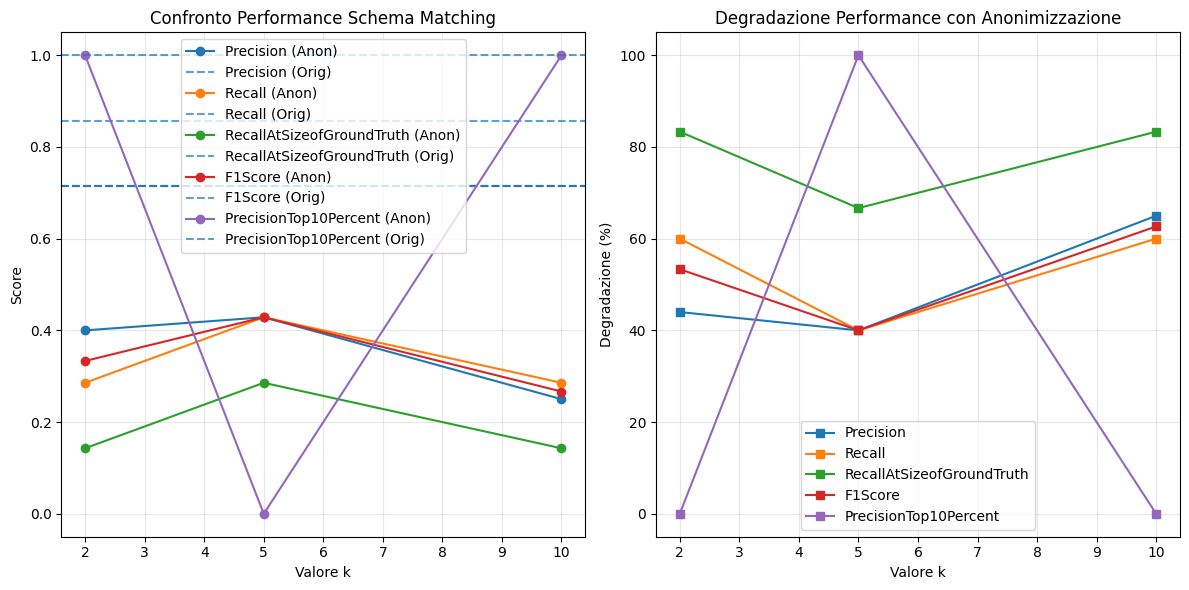


TABELLA DEGRADAZIONE:
                      Metrica   k  Score_Originale  Score_Anonimizzato  \
0                   Precision   2           0.7143              0.4000   
1                   Precision   5           0.7143              0.4286   
2                   Precision  10           0.7143              0.2500   
3                      Recall   2           0.7143              0.2857   
4                      Recall   5           0.7143              0.4286   
5                      Recall  10           0.7143              0.2857   
6   RecallAtSizeofGroundTruth   2           0.8571              0.1429   
7   RecallAtSizeofGroundTruth   5           0.8571              0.2857   
8   RecallAtSizeofGroundTruth  10           0.8571              0.1429   
9                     F1Score   2           0.7143              0.3333   
10                    F1Score   5           0.7143              0.4286   
11                    F1Score  10           0.7143              0.2667   
12      Precisi

In [40]:
print("\n CONFRONTO RISULTATI SCHEMA MATCHING")
print("=" * 60)

# Crea DataFrame per confronto
if matching_results:
    results_df = pd.DataFrame(matching_results)

    # Rimuovi duplicati per originale
    results_df_clean = results_df.drop_duplicates(subset=['Tipo', 'Metrica'])

    print("\n TABELLA CONFRONTO METRICHE:")
    print(results_df_clean.pivot_table(
        index='Metrica',
        columns=['Tipo', 'k'],
        values='Score',
        aggfunc='first'
    ).round(4))


# Visualizzazione grafica dei risultati
print("\n VISUALIZZAZIONE IMPATTO ANONIMIZZAZIONE")
print("=" * 60)

if matching_results:
    # Prepara dati per visualizzazione
    plot_data = []
    metrics_list = list(set([r['Metrica'] for r in matching_results]))

    for metric in metrics_list:
        original_score = next((r['Score'] for r in matching_results
                             if r['Tipo'] == 'Originale' and r['Metrica'] == metric), None)

        for k in k_values:
            anon_score = next((r['Score'] for r in matching_results
                             if r['Tipo'] == 'Anonimizzato' and r['k'] == k and r['Metrica'] == metric), None)

            if original_score is not None and anon_score is not None:
                degradation = ((original_score - anon_score) / original_score) * 100 if original_score > 0 else 0
                plot_data.append({
                    'Metrica': metric,
                    'k': k,
                    'Score_Originale': original_score,
                    'Score_Anonimizzato': anon_score,
                    'Degradazione_%': degradation
                })

    if plot_data:
        plot_df = pd.DataFrame(plot_data)

        # Grafico degradazione
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        for metric in metrics_list:
            metric_data = plot_df[plot_df['Metrica'] == metric]
            plt.plot(metric_data['k'], metric_data['Score_Anonimizzato'],
                    marker='o', label=f'{metric} (Anon)')
            plt.axhline(y=metric_data['Score_Originale'].iloc[0],
                        linestyle='--', alpha=0.7, label=f'{metric} (Orig)')


        plt.xlabel('Valore k')
        plt.ylabel('Score')
        plt.title('Confronto Performance Schema Matching')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        for metric in metrics_list:
            metric_data = plot_df[plot_df['Metrica'] == metric]
            plt.plot(metric_data['k'], metric_data['Degradazione_%'],
                    marker='s', label=metric)

        plt.xlabel('Valore k')
        plt.ylabel('Degradazione (%)')
        plt.title('Degradazione Performance con Anonimizzazione')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("\nTABELLA DEGRADAZIONE:")
        print(plot_df[['Metrica', 'k', 'Score_Originale', 'Score_Anonimizzato', 'Degradazione_%']].round(4))


### Chiusura JVM

In [ ]:
if jpype.isJVMStarted():
    jpype.shutdownJVM()
    print("JVM chiusa correttamente")